<a href="https://colab.research.google.com/github/luckyme410/classify_champ/blob/main/mBert_ruBert_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## В приведенном ноутбуке мы будем классифицировать спортивные статьи с Чемпионат.com (https://www.championat.com/). Статьи выбраны по 7 видам спорта (футбол, баскетбол, хоккей, ...) их и будем предсказывать, т.е. решается задача многоклассовой классификации. Предсказывать о каком виде спорта идет речь в статье, мы будем по ее заголовку и подзаголовку.

## Глава 1. Загрузка и анализ данных

In [ ]:
! pip install datasets transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style('darkgrid')

### Загрузим данные:

In [ ]:
! unzip articles_championat.zip

Archive:  articles_championat.zip
  inflating: content/articles_championat.csv  


In [ ]:
data = pd.read_csv("/content/content/articles_championat.csv")
print('Кол-во статей:', data.shape[0])
print()
data.head()

Кол-во статей: 16047



,text,title,subtitle,date,sport
0,"В то время пока «Ред Булл» близится к тому, чт...",10 худших команд в истории Формулы-1. От дерев...,Одна из команд была связана с Советским Союзом.,"16 июля 2023, 11:30 МСК",auto
1,Авторитетный обозреватель Формулы-1 Джо Сейвуд...,"Норрис в «Феррари», Леклер в «Мерседесе»?! Раз...",Через год Формулу-1 могут подкараулить мощнейш...,"15 июля 2023, 12:30 МСК",auto
2,В марте ФИА открыла приём заявок на участие в ...,Скучаете по шинным войнам в Формуле-1? Вот 2 п...,"Хэмилтон за возвращение дуэли шинников, но это...","14 июля 2023, 12:30 МСК",auto
3,Свершилось. Ника де Вриса всё-таки уволили из ...,"8 громких случаев, когда пилоты Формулы-1 поки...",Однажды «Феррари» выгнала гонщика уже после пе...,"13 июля 2023, 16:30 МСК",auto
4,Одним из главных трансферных активов этого лет...,Звезда IndyCar рвётся в Ф-1. Но у Палоу не пол...,"Алекс, безусловно, талантлив, но выстрелить ср...","12 июля 2023, 17:00 МСК",auto


In [ ]:
# описание столбцов:

# text - статья
# title - ее заголовок
# subtitle - подзаголовок статьи
# date - дата публикации (str)
# sport - вид спорта



In [ ]:
# для предсказания о каком виде спорта (sport) идет речь в статье, используем только заголовок (title) и подзаголовок (subtitle)
names = ['title', 'subtitle', 'sport']
data = data[names]

In [ ]:
# соединим title & subtitle в одну строку:
data['title'] = data['title'].apply(lambda txt: txt + ' ' if txt[-1] in '.?!;' else txt + '. ')
data['title&subtitle'] = data['title'] + data['subtitle']

<ipython-input-6-d09c71b2f11a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['title'] = data['title'].apply(lambda txt: txt + ' ' if txt[-1] in '.?!;' else txt + '. ')
<ipython-input-6-d09c71b2f11a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['title&subtitle'] = data['title'] + data['subtitle']


In [ ]:
# взглянем что получилось:
data['title&subtitle'].values[:5].tolist()

['10 худших команд в истории Формулы-1. От деревенских энтузиастов до «Ламборгини». Одна из команд была связана с Советским Союзом.',
 'Норрис в «Феррари», Леклер в «Мерседесе»?! Разбираем свежие трансферные слухи. Через год Формулу-1 могут подкараулить мощнейшие перестановки.',
 'Скучаете по шинным войнам в Формуле-1? Вот 2 причины, почему монополия неизбежна. Хэмилтон за возвращение дуэли шинников, но это лишь мечты.',
 '8 громких случаев, когда пилоты Формулы-1 покидали команду прямо по ходу сезона. Однажды «Феррари» выгнала гонщика уже после первого этапа.',
 'Звезда IndyCar рвётся в Ф-1. Но у Палоу не получится стать новым Монтойей и Вильнёвом. Алекс, безусловно, талантлив, но выстрелить сразу у него вряд ли получится.']

### Анализ данных


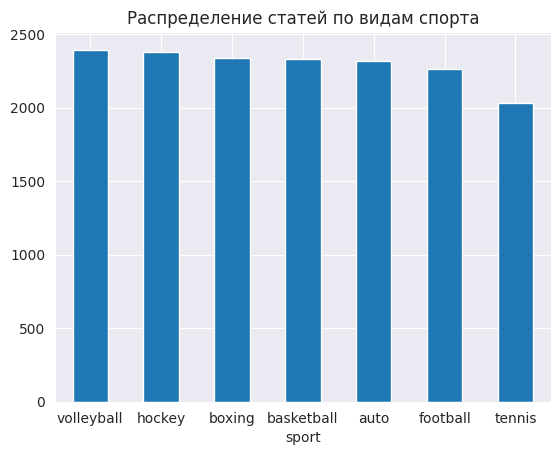

In [ ]:
# какие виды спорта представлены, сколько их всего, есть ли дисбаланс классов, наличие пропусков:
data['sport'].value_counts(dropna=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Распределение статей по видам спорта');

Всего 7 классов,
пропусков нет,
только теннис немного просел, считаем классы сбалансированными.
Зависит ли длина заголовков и кол-во цифр в них от вида спорта?

In [ ]:
%%time
# длина заголовков:
data['title&subtitle_len'] = data['title&subtitle'].apply(lambda txt: len(txt))

# кол-во цифр в заголовке:
data['digit_num'] = data['title&subtitle'].apply(lambda txt: sum(1 for char in txt if char.isdigit()))

CPU times: user 244 ms, sys: 5.64 ms, total: 249 ms
Wall time: 249 ms


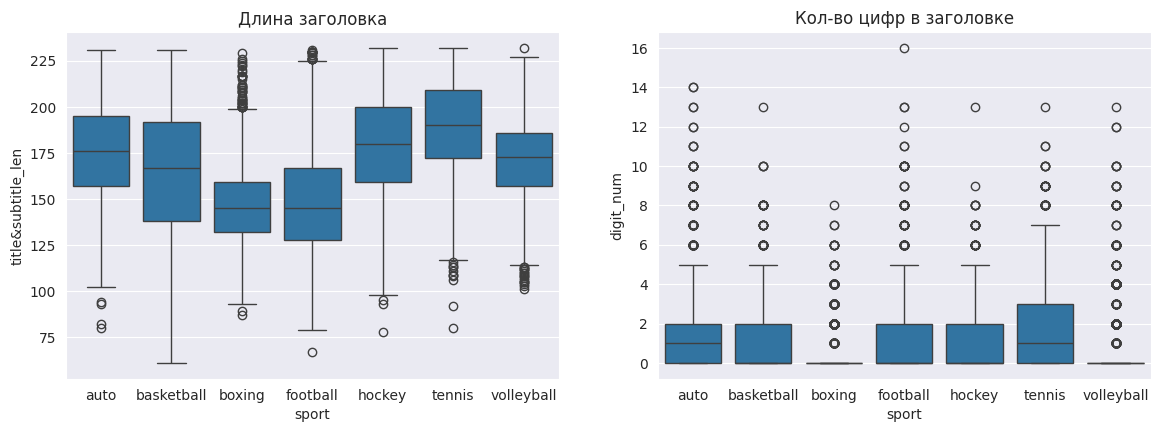

In [ ]:
plt.figure(figsize=(14., 4.5))
# распределение длин заголовков по видам спорта:
ax1 = plt.subplot(1,2,1)
sns.boxplot(data=data,
            x='sport',
            y='title&subtitle_len',
            ax=ax1)
plt.title('Длина заголовка')

ax2 = plt.subplot(1,2,2)
sns.boxplot(data=data,
            x='sport',
            y='digit_num',
            ax=ax2)
plt.title('Кол-во цифр в заголовке');


Теннис чемпион по длине заголовка, а футбол и бокс заметно отстают.
В боксе и воллейболе цифры - редкость, а вот в теннисе и автоспорте нет.

In [ ]:
# исследовать распределение частей речи (POS) по классам
# not today...

### Dataset
Преобразуем данные в Dataset формат для удобства их обработки

In [ ]:
import datasets

In [ ]:
# данные будут в формате Dataset:
dataset = datasets.Dataset.from_pandas(data.loc[:, ['title&subtitle', 'sport']])
dataset = dataset.shuffle(seed=12)

# сменим имя title&subtitle -> text:
dataset = dataset.rename_column('title&subtitle', 'text')

In [ ]:
# разделим на train/eval части:
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=14)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'sport'],
        num_rows: 12837
    })
    test: Dataset({
        features: ['text', 'sport'],
        num_rows: 3210
    })
})

In [ ]:
# пронумеруем каждый вид спорта:
N = 7 # видов спорта в датасете
label2id = {k: v for k, v in zip(data['sport'].value_counts().index, range(N))}
id2label = {v: k for k, v in label2id.items()}
print(label2id)

{'volleyball': 0, 'hockey': 1, 'boxing': 2, 'basketball': 3, 'auto': 4, 'football': 5, 'tennis': 6}


## Глава 2. ruBert vs mBert

### Выбор модели
Сравним работу двух encoder'ов

In [ ]:
#model_checkpoint = "DeepPavlov/rubert-base-cased"
model_checkpoint = "google-bert/bert-base-multilingual-cased"

### Preprocessing

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer.is_fast

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

True

In [ ]:
# токенизируем тексты и заменим вид спорта на чиселки:

def preprocessing(examples):
  # токенизация:
  inputs = tokenizer(examples['text'],
                     return_tensors='np',
                     max_length=256,
                     truncation=True)
  examples['input_ids'] = inputs['input_ids']
  examples['attention_mask'] = inputs['attention_mask']
  # sport mapping:
  examples['labels'] = [label2id[sport] for sport in examples['sport']]

  return examples

In [ ]:
tokenized_dataset = dataset.map(preprocessing, batched=True)

Map:   0%|          | 0/12837 [00:00<?, ? examples/s]

Map:   0%|          | 0/3210 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'sport', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12837
    })
    test: Dataset({
        features: ['text', 'sport', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3210
    })
})

In [ ]:
# пример:
for k,v in tokenized_dataset['test'][0].items():
  print(k+': ', v)

text:  Уникальные фото Формулы-1: в Турции машины приобрели очень необычный вид. Как вам, к примеру, зеркала заднего вида, в которых вообще ничего не видно?
sport:  auto
input_ids:  [101, 57280, 6908, 20486, 31993, 130, 138, 156, 845, 15555, 14798, 36427, 7805, 63608, 3810, 132, 5405, 29526, 128, 861, 20807, 128, 47087, 46356, 14684, 128, 845, 5327, 17050, 14179, 1699, 26506, 166, 102]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels:  4


In [ ]:
# удалим text и sport:
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'sport'])

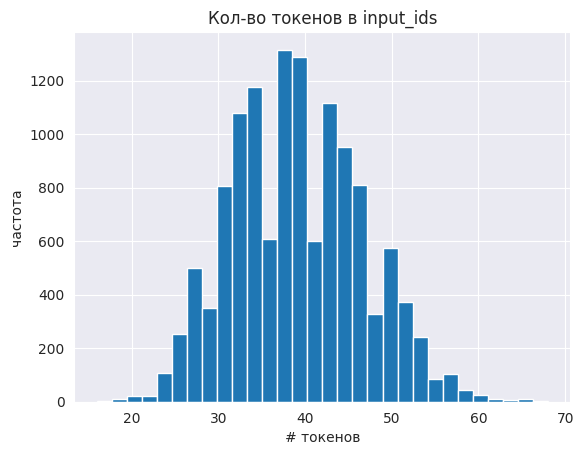

In [ ]:
# кол-во токенов в input_ids:
num_tokens = list(map(len, tokenized_dataset['train']['input_ids']))
plt.hist(num_tokens, bins=30)
plt.title('Кол-во токенов в input_ids')
plt.xlabel("# токенов")
plt.ylabel('частота');

Максимальное число токенов ~ 70, в токинизаторе max_length=128 что существенно больше чем 70. Т.е. мы ничего не обрезали и не потеряли никакую информацию

### Импорт модели + data_collator

In [ ]:
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=len(label2id), id2label=id2label, label2id=label2id,
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# т.к. данные подаются в модель параллельно, они должны быть одной длины.
# добить input_ids pad_token'ми до одной длины нам поможет data_collator
# и заодно attention_mask заполнит 0 для игнора векторов от pad_token'ов

data_collator = DataCollatorWithPadding(tokenizer)

### Dataloader

In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# обучающая и тестовая выборки для модели:
train_loader = DataLoader(tokenized_dataset['train'],
                          batch_size=16,
                          shuffle=True,
                          collate_fn=data_collator)


test_loader = DataLoader(tokenized_dataset['test'],
                          batch_size=16,
                          shuffle=False,
                          collate_fn=data_collator)

In [ ]:
# проверим работу:
for x_batch in test_loader:
  break

{k: v.shape for k,v in x_batch.items()}

{'input_ids': torch.Size([16, 69]),
 'attention_mask': torch.Size([16, 69]),
 'labels': torch.Size([16])}

<Axes: >

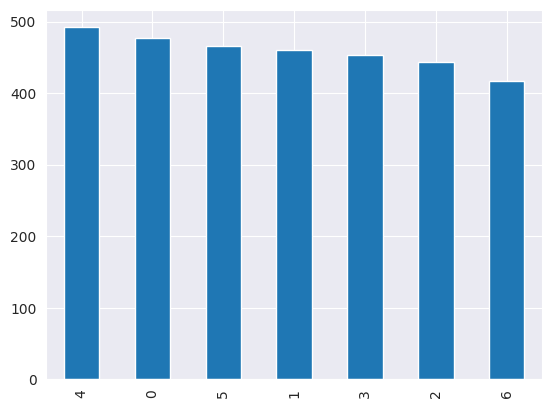

In [ ]:
# распределение классов в test, вдруг неравномерно разделили данные:
pd.Series(tokenized_dataset['test']['labels']).value_counts().plot(kind='bar')

### Model to GPU/CPU

In [ ]:
# device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm

### Качество модели до fine-tuning'а
Модель можно разделить на 2 части: encoder и classifier
веса во второй части - рандомные, в первой - нет.
Поэтому без fine-tuning'a модель должна угадывать примерно 1/7 ответов,
давайте это проверим

In [ ]:
# доля случайных угадываний:
round(1/7, 3)

0.143

In [ ]:
eval_loss = 0
N_sample = len(tokenized_dataset['test'])
y_pred = []
#_ = 0

model.eval()
for x_batch in tqdm(test_loader):
  #_ += 1
  x_batch = {k: v.to(device) for k,v in x_batch.items()}
  with torch.no_grad():
    output = model(**x_batch)
  loss = output['loss'].cpu().item()
  logits = output['logits'].cpu()

  eval_loss += loss
  preds = logits.argmax(dim=-1).tolist()
  y_pred += preds
  #if _ == 15:
  #  break

100%|██████████| 201/201 [00:14<00:00, 13.55it/s]


In [ ]:
y_true = tokenized_dataset['test']['labels'][:len(y_pred)]

In [ ]:
print('eval loss w/o fine-tuning:', round(eval_loss / len(y_true), 4))
print('accuracy:', round(accuracy_score(y_true, y_pred), 4),  'random label choice:', round(1/7, 4))
print('precision:', round(precision_score(y_true, y_pred, average='macro', zero_division='warn'), 4))
print('recall:', round(recall_score(y_true, y_pred, average='macro'), 4))
print('F1:', round(f1_score(y_true, y_pred, average='macro'), 4))

eval loss w/o fine-tuning: 0.1224
accuracy: 0.1302 random label choice: 0.1429
precision: 0.032
recall: 0.1301
F1: 0.0483


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Доля угадываний =  0.1302 и это близко к 0.143, все хорошо.

### Fine-tuning модели:
Используем train'овые данные для подправки модели.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
# думаю, для classifier слой требуется больший lr чем для остального encoder'a:
#param_groups = []
#for name, parameter in model.named_parameters():
#  if 'classifier' in name:
#    param_groups.append({'params': [parameter], 'lr': 3e-4})

In [ ]:
optim = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)  #

In [ ]:
# scheduler:

N_epochs = 3 # 3 эпохи обучения
n_train_steps = len(train_loader) * (N_epochs + 1)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optim,
    num_warmup_steps=0,
    num_training_steps=n_train_steps)

In [ ]:
# train/eval loops:
loss_hist = [] # train loss history
eval_loss_hist = [] # eval loss history
y_true = tokenized_dataset['test']['labels']
N_sample = len(tokenized_dataset['test'])
#_ = 0

for epoch in range(1, N_epochs+1):
  model.train()
  for x_batch in tqdm(train_loader):
    # to device:
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    #_ += 1

    optim.zero_grad()
    output = model(**x_batch)
    output['loss'].backward()
    # clip grads:
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optim.step()

    # get and save loss:
    loss = output['loss'].detach().cpu().item()
    loss_hist.append(loss)

    # scheduler step:
    lr_scheduler.step()

    #if _ == 10:
    #  break

  #_ = 0
  # eval:
  eval_loss = 0 # eval
  y_pred = [] # eval
  model.eval()
  for x_batch in tqdm(test_loader):
    #_ += 1
    x_batch = {k: v.to(device) for k,v in x_batch.items()}
    with torch.no_grad():
      output = model(**x_batch)
    loss = output['loss'].cpu().item()
    logits = output['logits']

    eval_loss += loss#.cpu().item()
    eval_loss_hist.append(loss)#.cpu().item())
    preds = logits.cpu().argmax(dim=-1).tolist()
    y_pred += preds

    #if _ == 20:
    #  break


  # metrics:
  #y_pred = net_pred
  n = len(y_pred)
  print(f'\nepoch: {epoch} \t\tmodel: {model_checkpoint}')
  print(f'eval loss: {round(eval_loss/n, 4)}')
  print(f'accuracy: {round(accuracy_score(y_true[:n], y_pred), 4)}')
  print(f"precision: {round(precision_score(y_true[:n], y_pred, average='macro'), 4)}")
  print(f"recall: {round(recall_score(y_true[:n], y_pred, average='macro'), 4)}")
  print(f"f1: {round(f1_score(y_true[:n], y_pred, average='macro'), 4)}")
  print()


100%|██████████| 201/201 [00:14<00:00, 13.45it/s]



epoch: 1 		model: google-bert/bert-base-multilingual-cased
eval loss: 0.0116
accuracy: 0.9417
precision: 0.9422
recall: 0.9416
f1: 0.9418



100%|██████████| 201/201 [00:14<00:00, 13.72it/s]



epoch: 2 		model: google-bert/bert-base-multilingual-cased
eval loss: 0.0096
accuracy: 0.9474
precision: 0.9475
recall: 0.9473
f1: 0.9472



100%|██████████| 201/201 [00:14<00:00, 13.75it/s]


epoch: 3 		model: google-bert/bert-base-multilingual-cased
eval loss: 0.0087
accuracy: 0.953
precision: 0.9554
recall: 0.9524
f1: 0.9532



Заветные 95% качества выбиты, все ок. Сравним результаты с ruBert'ом

In [ ]:
#                                        model: DeepPavlov/rubert-base-cased
# epoch: 1
# eval loss: 0.0077
# accuracy: 0.9573
# precision: 0.9597
# recall: 0.9568
# f1: 0.9577

# epoch: 2
# eval loss: 0.0072
# accuracy: 0.9598
# precision: 0.9614
# recall: 0.9592
# f1: 0.9599

# epoch: 3
# eval loss: 0.0067
# accuracy: 0.9626
# precision: 0.9623
# recall: 0.9624
# f1: 0.9622


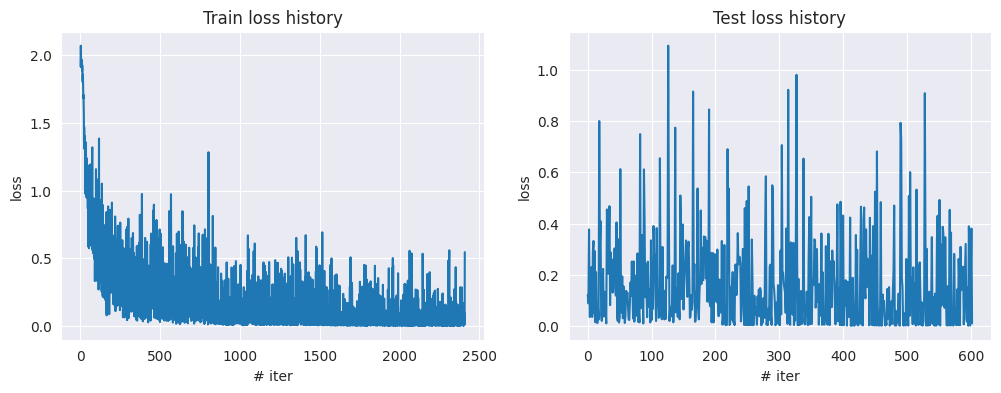

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(loss_hist)
plt.title('Train loss history')
plt.xlabel('# iter')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(eval_loss_hist)
plt.title('Test loss history')
plt.xlabel('# iter')
plt.ylabel('loss');

Рассмотрим матрицу ошибок чтобы оценить какие классы модель путает и заодно выведем примеры ошибочных предсказаний

In [ ]:
conf_df = pd.DataFrame(confusion_matrix(y_true[:n], y_pred,),
                       index=[id2label[k] for k in id2label],
                       columns=[id2label[k] for k in id2label]
)

In [ ]:
conf_df

,volleyball,hockey,boxing,basketball,auto,football,tennis
volleyball,456,0,0,8,0,10,3
hockey,1,440,0,8,0,12,0
boxing,1,4,421,5,0,9,4
basketball,10,5,0,414,2,21,1
auto,0,3,0,4,481,4,0
football,0,3,0,6,1,455,1
tennis,0,4,0,3,1,17,392


In [ ]:
# на каких заголовках нейронка ошибается:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
mask_err = (y_pred != y_true)

# всего ошибок:
mask_err.sum()

151

In [ ]:
# примеры ошибочной классификации:
_ = 0
for i in range(len(mask_err)):
  if mask_err[i]:
    print(dataset['test']['text'][i])
    print(f'sport: {id2label[y_true[i]]}  guess: {id2label[y_pred[i]]}')
    print()
    _ += 1
  if _ == 20:
    break

Захарян, Шлеменко и ожидание US Open. Главное за неделю. Всё важное и интересное — в материалах «Чемпионата».
sport: tennis  guess: hockey

7 топ-матчей понедельника: Александрова, Медведев и Андреева рвутся в 1/4 Уимблдона. Что интересного в спорте сегодня, 10 июля: классный теннис в Лондоне, рубка США против Канады в футболе и Летняя лига НБА.
sport: basketball  guess: tennis

Шведская легенда одним ударом уложил белорусского Уборщика. Хорошая разминка перед Джонсом. Жаль, что 40-летний Матюшенко не ушёл на пенсию своевременно.
sport: boxing  guess: hockey

Пока Россия проигрывает Ирану, Аргентина «привозит» 39 очков Америке. Наш главный соперник по группе на Кубке мира — 2019 победил в Панамериканских играх, разгромив сборную США.
sport: basketball  guess: volleyball

10 топ-матчей субботы: Рублёв и Потапова в полуфиналах, Португалия — Нидерланды на Евро. Расписание на 24 июня: яркий теннис с нашими, волейбольная Лига наций и зарубы на Евро-2023 U21.
sport: volleyball  guess: footba

In [ ]:
# очистимся:
del model
del tokenizer

## Глава 3. mT5
[m]T5  можно использовать несколькими способами для классификации текстов:
во-первых, генерить и предсказывать вид спорта как текст: футбол, баскетбол, ...  (MT5ForConditionalGeneration)
во-вторых, довесить классификационную часть поверх mT5  (MT5ForSequenceClassification)
в-третьих, использовать только encoder часть и к нему прикрутить классификатор - это мы и реализуем ниже (MT5EncoderModel).

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# is fast:
tokenizer.is_fast

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


True

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'sport'],
        num_rows: 12837
    })
    test: Dataset({
        features: ['text', 'sport'],
        num_rows: 3210
    })
})

In [ ]:
# в dataset хранятся заголовки и вид спорта
# преобразуем их сызнова токенизатором от mT5
# и заменим виды спорта на числа

def preprocessing(examples):
    labels = list(map(lambda txt: label2id[txt], examples['sport']))
    examples['labels'] = labels

    return tokenizer(examples['text'], max_length=128, truncation=True, return_tensors='np')

In [ ]:
tokenized_dataset = dataset.map(preprocessing, batched=True)

Map:   0%|          | 0/12837 [00:00<?, ? examples/s]

Map:   0%|          | 0/3210 [00:00<?, ? examples/s]

In [ ]:
# пример:
for k, v in tokenized_dataset['test'][1].items():
  print(k+': ', v)

text:  Разгорающийся скандал вокруг Ничушкина и триумф «Чайки» в МХЛ. Итоги дня в хоккее. Сезон в КХЛ продолжается, а знаковый игрок СКА закончил игровую карьеру.
sport:  hockey
labels:  1
input_ids:  [10161, 73124, 128190, 97678, 315, 67289, 6872, 1531, 47002, 558, 259, 279, 6035, 4766, 3378, 404, 120727, 657, 436, 315, 1278, 3391, 6125, 260, 156652, 51843, 259, 12515, 315, 100113, 1625, 324, 260, 688, 111524, 315, 1035, 3391, 6125, 18713, 7990, 261, 259, 308, 4778, 122972, 9681, 1358, 259, 57230, 6297, 35437, 9681, 44531, 259, 154454, 80726, 260, 1]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# удалим text и sport:
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'sport',])

### Data_collator

In [ ]:
import torch
from transformers import DataCollatorWithPadding

In [ ]:
# т.к. данные подаются в модель параллельно, они должны быть одной длины.
# добить input_ids pad_token'ми до одной длины нам поможет data_collator

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# загрузчики данных для нейронки:
train_loader = DataLoader(tokenized_dataset['train'],
                          batch_size=32,
                          shuffle=True,
                          collate_fn=data_collator)


test_loader = DataLoader(tokenized_dataset['test'],
                          batch_size=32,
                          shuffle=False,
                          collate_fn=data_collator)

In [ ]:
# работает:
for x_batch in train_loader:
  break

{k: v.shape for k,v in x_batch.items()}

{'labels': torch.Size([32]),
 'input_ids': torch.Size([32, 78]),
 'attention_mask': torch.Size([32, 78])}

### Model
Пару слов о модели:
от mT5 берем encoder часть и к ней добавляем линейный слой с 7 выходами (число классов).
Вектора токенов на выходе encoder'a усредняем (игноря вектора от pad_token'ов),
эти усредненные и подаем в линейный слой (классификатор) и получаем логиты по 7 классам.
Считаем лосс (CrossEntropyLoss), считаем градиенты и обновляем веса.

In [ ]:
from transformers import MT5EncoderModel

model = MT5EncoderModel.from_pretrained(model_checkpoint)

In [ ]:
import torch.nn

In [ ]:
class myT5(torch.nn.Module):
  def __init__(self, n_classes):
    """
    mT5 encoder block + linear layer
    """
    super().__init__()

    self.encoderT5 = model
    self.clf = torch.nn.Linear(512, n_classes)  # 512 - размерность векторов токенов на выходе из encoder'a

  def forward(self, x_batch):
    # кол-во токенов в input_ids, кроме pad_token'ов:
    den = x_batch['attention_mask'].sum(dim=1, keepdim=True) # (bs, 1)
    # чтобы игнорировать выходы pad_token'ов:
    attn_mask = x_batch['attention_mask'].unsqueeze(dim=-1) # (bs, seq_len, 1)

    outp = self.encoderT5(**x_batch)
    # вектора токенов на выходе из Encoder'a
    hidden_state = outp.last_hidden_state # (bs, seq_len, hid_dim)

    # усреднем вектора, игнорируя вектора pad_token'ов:
    clf_input = (hidden_state * attn_mask).sum(dim=1) / den  # (bs, hid_dim)
    assert clf_input.shape[1] == 512, 'Wrong math!'

    # clf:
    clf_outp = self.clf(clf_input) # (bs, n_classуы)

    return clf_outp

In [ ]:
# N = 7
custom_model = myT5(N)

### Move to GPU/CPU

In [ ]:
# device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
custom_model.to(device)

myT5(
  (encoderT5): MT5EncoderModel(
    (shared): Embedding(250112, 512)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 512)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MT5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
                (wi_1): Linear(in_feat

### Fine-tuning модели

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
from torch.nn import CrossEntropyLoss

In [ ]:
#param_groups = []#[{'params': model['classification_head'], 'lr': 5e-4}]
#for name, parameter in model.named_parameters():
#  if 'clf' in name:
#    param_groups.append({'params': [parameter], 'lr': 6e-4})

In [ ]:
optim = AdamW(custom_model.parameters(), lr=3e-4, weight_decay=0.01)  # param_groups

In [ ]:
# лосс функция, замеряющая ошибки:
loss_fn = CrossEntropyLoss()

In [ ]:
# scheduler:

N_epochs = 4
n_train_steps = len(train_loader) * N_epochs

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optim,
    num_warmup_steps=0,
    num_training_steps=n_train_steps)

In [ ]:
# train/eval loops:

loss_hist = [] # train loss history
y_true = tokenized_dataset['test']['labels']
N_sample = len(tokenized_dataset['test'])

for epoch in range(1, N_epochs+1):
  #_ = 0
  custom_model.train()
  for x_batch in tqdm(train_loader):
    labels = x_batch['labels']
    del x_batch['labels']

    # to device:
    x_batch = {k: v.to(device) for k,v in x_batch.items()}

    #_ += 1
    optim.zero_grad()
    output = custom_model(x_batch)
    loss = loss_fn(output, labels.to(device))
    loss.backward()

    # clip grads:
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optim.step()

    # get and save loss:
    loss_hist.append(loss.detach().cpu().item())

    # scheduler step:
    lr_scheduler.step()

    #if _ == 25:
    #  break

  #_ = 0
  # eval:
  eval_loss = 0 # eval
  y_pred = [] # eval
  custom_model.eval()
  for x_batch in tqdm(test_loader):
    #_ += 1
    labels = x_batch['labels']
    del x_batch['labels']

    x_batch = {k: v.to(device) for k,v in x_batch.items()}

    with torch.no_grad():
      output = custom_model(x_batch)
    loss = loss_fn(output, labels.to(device))
    eval_loss += loss.cpu().item()

    preds = output.cpu().argmax(dim=-1).tolist()
    y_pred += preds

    #if _ == 15:
    #  break


  # metrics:
  n = len(y_pred)
  print(f'\nepoch: {epoch}')
  print(f'eval loss: {round(eval_loss/len(y_pred), 5)}')
  print(f'accuracy: {round(accuracy_score(y_true[:n], y_pred), 5)}')
  print(f"precision: {round(precision_score(y_true[:n], y_pred, average='macro'), 5)}")
  print(f"recall: {round(recall_score(y_true[:n], y_pred, average='macro'), 5)}")
  print(f"f1: {round(f1_score(y_true[:n], y_pred, average='macro'), 5)}")
  print()


100%|██████████| 101/101 [00:04<00:00, 24.46it/s]



epoch: 1
eval loss: 0.01188
accuracy: 0.87882
precision: 0.8954
recall: 0.87819
f1: 0.87999



100%|██████████| 101/101 [00:04<00:00, 23.26it/s]



epoch: 2
eval loss: 0.00834
accuracy: 0.91994
precision: 0.92147
recall: 0.91972
f1: 0.91987



100%|██████████| 101/101 [00:04<00:00, 22.67it/s]



epoch: 3
eval loss: 0.00735
accuracy: 0.93053
precision: 0.93025
recall: 0.93043
f1: 0.93017



100%|██████████| 101/101 [00:04<00:00, 23.35it/s]



epoch: 4
eval loss: 0.00689
accuracy: 0.93333
precision: 0.93334
recall: 0.93316
f1: 0.93306



Результаты очень близки к ruBert/mBert, в каких-то прогонах у меня выбивалось качество под 94.5%, надо поварьировать гиперпараметры  

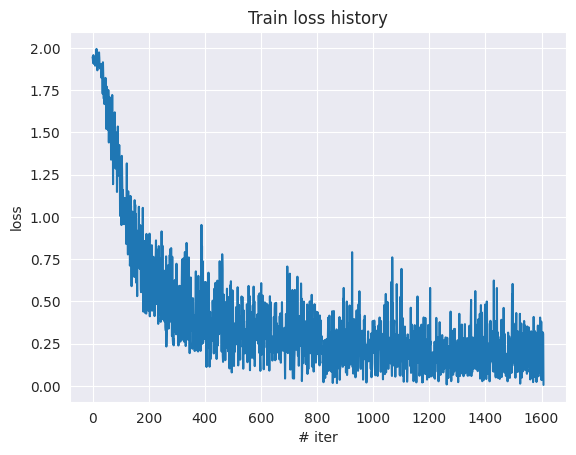

In [ ]:
plt.plot(loss_hist)
plt.title('Train loss history')
plt.xlabel('# iter')
plt.ylabel('loss');

In [ ]:
# Матрица ошибок предсказаний классов:
conf_df = pd.DataFrame(confusion_matrix(y_true[:n], y_pred,),
                       index=[id2label[k] for k in id2label],
                       columns=[id2label[k] for k in id2label]
)

NameError: name 'confusion_matrix' is not defined

In [ ]:
conf_df

,volleyball,hockey,boxing,basketball,auto,football,tennis
volleyball,449,4,3,6,0,10,5
hockey,1,426,0,15,1,13,5
boxing,0,4,418,7,0,3,12
basketball,15,5,6,406,0,14,7
auto,1,1,0,3,477,4,6
football,0,12,3,18,2,424,7
tennis,1,3,0,5,1,11,396
